In [ ]:
!pip install torch pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 41.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install ucimlrepo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from torch.distributions import constraints
import numpy as np

In [ ]:
from ucimlrepo import fetch_ucirepo
statlog_australian_credit_approval = fetch_ucirepo(id=143)
# data (as pandas dataframes)
X = statlog_australian_credit_approval.data.features
y = statlog_australian_credit_approval.data.targets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_ = y['A15']
X_clean, X_test, y_train, y_test = train_test_split(X_scaled, y_, test_size=0.2, random_state=42)

In [ ]:
X_clean = torch.tensor(X_clean, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Add Noise

In [ ]:
def add_noise_to_data(X, noise_factor=0.8, outlier_fraction = 0.1, outlier_scale=5):
    noise = noise_factor * torch.randn_like(X)
    X_noisy = X + noise
    X_noisy = torch.clamp(X_noisy, 0, 1)

    num_outliers = int(outlier_fraction * X.shape[0])  # Determine number of outlier points
    outlier_indices = torch.randint(0, X.shape[0], (num_outliers,))  # Randomly select outlier positions
    X_outliers = torch.randn_like(X[outlier_indices]) * outlier_scale  # Scale up for extreme values
    X_noisy[outlier_indices] = X_outliers
    return X_noisy

X_train = add_noise_to_data(X_clean, noise_factor = 1.2, outlier_fraction=0.05)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([552, 14])
X_test shape: (138, 14)
y_train shape: torch.Size([552])
y_test shape: (138,)


In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [ ]:
pyro.clear_param_store()

In [ ]:
def model_MVN(X, y):
    w_prior = dist.MultivariateNormal(torch.zeros(X.shape[1]), torch.eye(X.shape[1]))  # Multivariate Normal for weights
    b_prior = dist.Normal(0., 1.)  # Normal prior for the bias

    # Sample weights and bias from the priors
    w = pyro.sample('w_MVN', w_prior)
    b = pyro.sample('b_MVN', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)  # Sigmoid activation for binary classification

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):  # Plate to represent the batch dimension
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)


def guide_MVN(X, y):
    # Define variational parameters for the weights and bias
    # Variational parameters for weights and bias
    w_loc = pyro.param('w_loc_MVN', torch.randn(X.shape[1]))  # Mean of variational distribution for weights
    w_scale = pyro.param('w_scale_MVN', torch.ones(X.shape[1]), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for weights
    b_loc = pyro.param('b_loc_MVN', torch.randn(1))  # Mean of variational distribution for bias
    b_scale = pyro.param('b_scale_MVN', torch.ones(1), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for bias

    # Variational distribution for the weights: Multivariate Normal
    # Using a diagonal covariance matrix for the variational distribution (for simplicity)
    w_cov = torch.diag(w_scale)  # Covariance matrix for the variational distribution
    pyro.sample('w_MVN', dist.MultivariateNormal(w_loc, w_cov))  # Multivariate Normal for weights

    # Variational distribution for the bias
    pyro.sample('b_MVN', dist.Normal(b_loc, b_scale))  # Normal for bias


# Optimizer setup
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_MVN = SVI(model_MVN, guide_MVN, optimizer, loss=Trace_ELBO())

# Train the model with Stochastic Variational Inference (SVI)
num_steps = 5000
for step in range(num_steps):
    loss = svi_MVN.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")


Step 0, Loss: 1020.3308715820312
Step 100, Loss: 676.7306798696518
Step 200, Loss: 583.7395913600922
Step 300, Loss: 452.051833987236
Step 400, Loss: 452.74874329566956
Step 500, Loss: 447.94335520267487
Step 600, Loss: 497.3743095397949
Step 700, Loss: 402.7947328090668
Step 800, Loss: 394.973930478096
Step 900, Loss: 386.6047817468643
Step 1000, Loss: 381.0115085840225
Step 1100, Loss: 415.61843144893646
Step 1200, Loss: 388.0287722349167
Step 1300, Loss: 372.21589410305023
Step 1400, Loss: 357.6725958585739
Step 1500, Loss: 360.52911853790283
Step 1600, Loss: 368.2296093702316
Step 1700, Loss: 369.1386662721634
Step 1800, Loss: 360.85656678676605
Step 1900, Loss: 359.461985707283
Step 2000, Loss: 361.7702227830887
Step 2100, Loss: 368.2926777601242
Step 2200, Loss: 366.8845374584198
Step 2300, Loss: 370.17793095111847
Step 2400, Loss: 362.9583189487457
Step 2500, Loss: 359.9973055124283
Step 2600, Loss: 358.84702718257904
Step 2700, Loss: 363.74887907505035
Step 2800, Loss: 360.6790

In [ ]:
def model_T(X, y):
    # Define priors
    df = pyro.sample("df", dist.Gamma(2.0, 1.0))
    w_prior = dist.StudentT(df=df, loc=torch.zeros(X.shape[1]), scale=torch.ones(X.shape[1]))
    b_prior = dist.StudentT(df=df, loc=torch.zeros(1), scale=torch.ones(1))

    # Sample weights and bias from the priors
    w = pyro.sample('w_T', w_prior.to_event(1))
    b = pyro.sample('b_T', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)



def guide_T(X, y):
    # Define variational parameters for the weights and bias
    df_loc = pyro.param("df_loc", torch.tensor(2.0), constraint=dist.constraints.positive)
    w_loc = pyro.param('w_loc_T', torch.randn(X.shape[1]))
    w_scale = pyro.param('w_scale_T', torch.ones(X.shape[1]), constraint=torch.distributions.constraints.positive)
    b_loc = pyro.param('b_loc_T', torch.randn(1))
    b_scale = pyro.param('b_scale_T', torch.ones(1), constraint=torch.distributions.constraints.positive)

    # Variational distributions for the weights and bias
    pyro.sample("df", dist.Gamma(df_loc, torch.tensor(1.0)))
    pyro.sample('w_T', dist.StudentT(df=df_loc, loc=w_loc, scale=w_scale).to_event(1))
    pyro.sample('b_T', dist.StudentT(df=df_loc, loc=b_loc, scale=b_scale))



adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_T = SVI(model_T, guide_T, optimizer, loss=Trace_ELBO())
# Train the model with Stochastic Variational Inference (SVI)
num_steps = 5000
for step in range(num_steps):
    loss = svi_T.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")

Step 0, Loss: 541.9403276443481
Step 100, Loss: 690.1080411076546
Step 200, Loss: 516.9108493328094
Step 300, Loss: 461.66272431612015
Step 400, Loss: 505.2005591094494
Step 500, Loss: 440.84364304691553
Step 600, Loss: 405.46468448638916
Step 700, Loss: 412.3115758895874
Step 800, Loss: 427.3247066140175
Step 900, Loss: 361.86767134070396
Step 1000, Loss: 372.7325672209263
Step 1100, Loss: 392.17824751138687
Step 1200, Loss: 363.96828055381775
Step 1300, Loss: 362.92043966054916
Step 1400, Loss: 380.4665243625641
Step 1500, Loss: 375.9185483455658
Step 1600, Loss: 368.4697497487068
Step 1700, Loss: 364.39052480459213
Step 1800, Loss: 369.51364117860794
Step 1900, Loss: 372.651995241642
Step 2000, Loss: 362.92184340953827
Step 2100, Loss: 361.27407318353653
Step 2200, Loss: 365.27860713005066
Step 2300, Loss: 366.9547481536865
Step 2400, Loss: 368.22362518310547
Step 2500, Loss: 378.8037438392639
Step 2600, Loss: 365.9151408672333
Step 2700, Loss: 359.19024074077606
Step 2800, Loss: 36

In [ ]:
T_df_param = pyro.param("df_loc").detach().item()
T_scale_param_tensor = pyro.param('w_scale_T').detach()
T_mean_param_tensor = pyro.param('w_loc_T').detach()
T_bias_mean_param = pyro.param('b_loc_T').detach()
T_bias_scale_param = pyro.param('b_scale_T').detach()
MVN_scale_param_tensor = pyro.param('w_scale_MVN').detach()
MVN_mean_param_tensor = pyro.param('w_loc_MVN').detach()
MVN_bias_mean_param = pyro.param('b_loc_MVN').detach()
MVN_bias_scale_param = pyro.param('b_scale_MVN').detach()
r = np.diag(T_scale_param_tensor.numpy())

In [ ]:
r.shape

(14, 14)

In [ ]:
vi_posterior_t = [dist.StudentT(pyro.param("df_loc").detach().item(), pyro.param('w_loc_T').detach()[i], pyro.param('w_scale_T').detach()[i])for i in range(14)]
vi_posterior = dist.MultivariateNormal(loc = pyro.param('w_loc_MVN').detach(), covariance_matrix= torch.diag(pyro.param('w_scale_MVN').detach()))

# Pseudo BMA and Stacking for optimal weights

In [ ]:
import arviz as az
import pymc as pm

In [ ]:
rng = np.random.seed(2741)

In [ ]:
# Model 1: Multivariate Normal
with pm.Model() as model_mvnorm:
    # Priors (extracting from vi_posterior)
    intercept = pm.Normal('intercept', mu= MVN_bias_mean_param.numpy()[0], sigma= MVN_bias_scale_param.numpy()[0])
    coefs = pm.MvNormal('coefs', mu=vi_posterior.loc[0:].numpy(), cov=vi_posterior.covariance_matrix[:, :].numpy())


    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_0 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

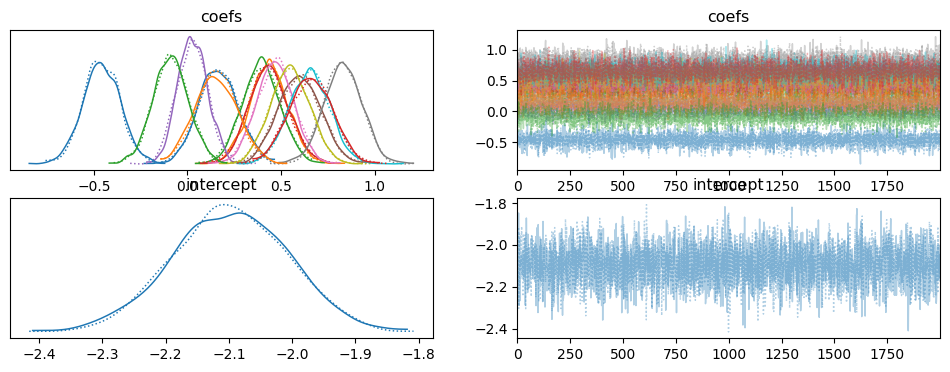

In [ ]:
pm.plot_trace(idata_0)

In [ ]:
# Model 2: Student T
with pm.Model() as model_studentt:
    # Priors (extracting from vi_posterior_t)
    intercept = pm.StudentT('intercept', mu= T_bias_mean_param.numpy()[0], sigma= T_bias_scale_param.numpy()[0], nu=T_df_param)
    coefs = pm.MvStudentT("coefs",mu=T_mean_param_tensor.numpy(),scale=r,nu=T_df_param)

    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_1 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)


Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

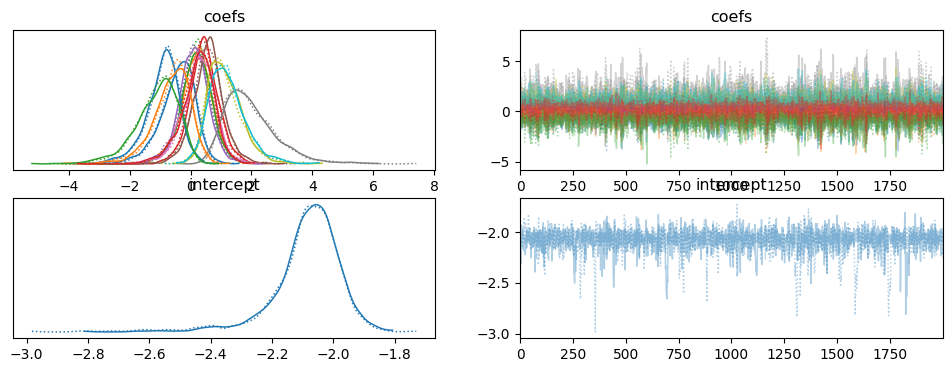

In [ ]:
pm.plot_trace(idata_1)

In [ ]:
model_dict = dict(zip(["model_mvnorm", "model_studentt"], [idata_0, idata_1]))
comp = az.compare(model_dict, method = "BB-pseudo-BMA")
comp

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_studentt,0,-367.718533,2.945186,0.000000,0.999815,4.710473,0.000000,True,log
model_mvnorm,1,-377.943539,0.553848,10.225006,0.000185,5.090956,1.708088,False,log


# Test Accuracy

In [ ]:
def predict_testset(X, num_samples=4000, w1=comp.loc['model_studentt', 'weight'], w2=comp.loc['model_mvnorm', 'weight']):
    # Student-T parameters
    df_loc = T_df_param
    w_loc_T = pyro.param('w_loc_T')
    w_scale_T = pyro.param('w_scale_T')
    b_loc_T = pyro.param('b_loc_T')

    # MVN parameters
    w_loc_MVN = pyro.param('w_loc_MVN')
    w_cov_MVN = torch.diag(pyro.param('w_scale_MVN'))
    b_loc_MVN = pyro.param('b_loc_MVN')
    b_scale_MVN = pyro.param('b_scale_MVN')

    # Sample mixture components
    mix_component = torch.bernoulli(torch.full((num_samples,), w1))  # Choose component
    mix_component_copy = mix_component.clone()

    # Sample weights directly from mixture model
    w_samples = torch.where(
        mix_component[:, None] == 1,
        dist.StudentT(df=df_loc, loc=w_loc_T, scale=w_scale_T).sample((num_samples,)),
        dist.MultivariateNormal(w_loc_MVN, w_cov_MVN).sample((num_samples,))
    )


    b_T_samples = dist.StudentT(df=df_loc, loc=b_loc_T, scale=torch.ones(1)).sample((num_samples,))
    b_MVN_samples = dist.Normal(b_loc_MVN, b_scale_MVN).sample((num_samples,))
    b_samples = torch.where(mix_component_copy[:, None] == 1, b_T_samples, b_MVN_samples)  # Ensure shape remains (2000,)

    # Compute logits
    logits = torch.matmul(X, w_samples.T) + b_samples.T
    probs = torch.sigmoid(logits).mean(dim=1)  # Average predictions

    return (probs > 0.5).float()  # Return binary predictions

In [ ]:
y_pred = predict_testset(X_test)
accuracy = (y_pred == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 75.3623%


In [ ]:
def predict(X, num_samples = 4000):
    # Get the learned parameters from the guide
    w_loc = pyro.param('w_loc_MVN')  # Mean of the weights
    w_cov = torch.diag(pyro.param('w_scale_MVN'))  # Covariance of the weights (diagonal for simplicity)
    b_loc = pyro.param('b_loc_MVN')  # Mean of the bias
    b_scale = pyro.param('b_scale_MVN')  # Std dev of the bias
    prob_samples = []
    for i in range(num_samples):
        # Sample from the variational distribution of w and b (posterior predictive sampling)
        w = dist.MultivariateNormal(w_loc, w_cov).sample()  # Sample weights
        b = dist.Normal(b_loc, b_scale).sample()  # Sample bias

        # Make predictions using the logistic model
        logits = torch.matmul(X, w) + b
        probs = torch.sigmoid(logits)
        prob_samples.append(probs)
    prob_samples = torch.stack(prob_samples)
    probs = prob_samples.mean(dim=0)
    return (probs > 0.5).float()  # Return binary predictions

# Predict on test data
y_pred_MVN = predict(X_test)

# Evaluate accuracy
accuracy = (y_pred_MVN == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 76.0870%
